# Pyro models

In [17]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [14]:
# Arrange the columns so that the years are in order
years = sorted([col for col in data.columns if col.startswith('y_')])
obs = data[years].values  # shape: [N, T]
obs = np.nan_to_num(obs, nan=0).astype(int)  # make sure there are no NaNs

# Encode gender: M=0, F=1
data['gender_code'] = (data['gender'] == 'F').astype(int)

# Normalize birth_year
birth_year_mean = data['birth_year'].mean()
birth_year_std = data['birth_year'].std()
data['birth_year_norm'] = (data['birth_year'] - birth_year_mean) / birth_year_std

years_num = np.array([int(y[2:]) for y in years])  # [2009, ..., 2023]
ages = years_num[None, :] - data['birth_year'].values[:, None]
# Normalize
ages_norm = (ages - ages.mean()) / ages.std()

# Covariates: example with birth_year_norm and gender_code
covariates = data[['birth_year_norm', 'gender_code']].values  # shape: [N, 2]

# Repeat covariates for all years (if fixed per individual)
covariates = np.repeat(covariates[:, None, :], len(years), axis=1)  # shape: [N, T, num_covariates]

# Convert everything to torch tensors
obs_torch = torch.tensor(obs, dtype=torch.long)
covariates_torch = torch.tensor(covariates, dtype=torch.float)

# Add normalized age as a covariate
covariates = np.concatenate([covariates, ages_norm[:, :, None]], axis=2)  # shape: [N, T, 3]
covariates_torch = torch.tensor(covariates, dtype=torch.float)

In [33]:
print(torch.min(obs_torch), torch.max(obs_torch))
num_obs = int(obs_torch.max().item()) + 1
assert obs_torch.min() >= 0 and obs_torch.max() < num_obs
print("Number of observations:", num_obs)


tensor(0) tensor(5)
Number of observations: 6


## HMM without covariates

In [32]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param(
        "emission_probs", torch.ones(num_states, num_obs) / num_obs,
        constraint=dist.constraints.simplex)
    trans_probs = pyro.param(
        "trans_probs", torch.ones(num_states, num_states) / num_states,
        constraint=dist.constraints.simplex)
    init_probs = pyro.param(
        "init_probs", torch.ones(num_states) / num_states,
        constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )

def guide(observations): pass

optimizer = Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Loss at step {step}: {loss}")

# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

ValueError: Error while computing log_prob at site 'obs_6':
Expected value argument (Tensor of shape (9236,)) to be within the support (IntegerInterval(lower_bound=0, upper_bound=4)) of the distribution Categorical(probs: torch.Size([9236, 5])), but found invalid values:
tensor([0, 3, 3,  ..., 0, 0, 0])
 Trace Shapes:       
  Param Sites:       
emission_probs    3 5
   trans_probs    3 3
    init_probs      3
 Sample Sites:       
  state_0 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_0 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_1 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_1 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_2 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_2 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_3 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_3 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_4 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_4 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_5 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_5 dist 9236 |
         value 9236 |
      log_prob 9236 |
  state_6 dist 9236 |
         value 9236 |
      log_prob 9236 |
    obs_6 dist 9236 |
         value 9236 |

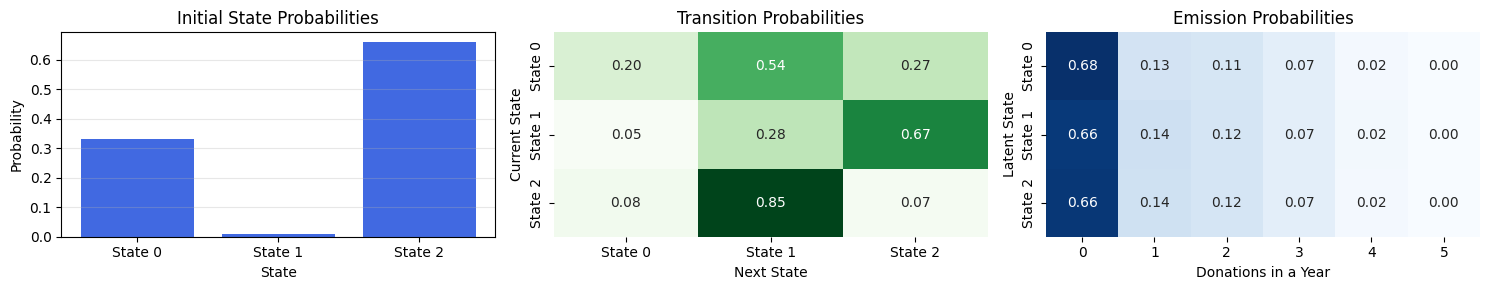

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

## Full Pyro

### Poisson

In [ ]:
def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

optimizer = Adam({"lr": .01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)


for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 82009.609375
Step 10 loss: 80865.6796875
Step 20 loss: 81323.609375
Step 30 loss: 81847.9921875
Step 40 loss: 80380.328125
Step 50 loss: 81442.578125
Step 60 loss: 84245.4921875
Step 70 loss: 80452.421875
Step 80 loss: 81385.890625
Step 90 loss: 83451.5078125
Step 100 loss: 79901.9375
Step 110 loss: 81988.1953125
Step 120 loss: 80305.9921875
Step 130 loss: 80334.578125
Step 140 loss: 81521.140625
Step 150 loss: 80630.328125
Step 160 loss: 79881.7578125
Step 170 loss: 80874.7265625
Step 180 loss: 81145.3359375
Step 190 loss: 80094.546875


In [ ]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.04238882 0.79057825 0.16703294]
Transition matrix (normalized): [[0.14046296 0.00395057 0.00127351]
 [0.02515006 0.43741775 0.0155309 ]
 [0.00888791 0.00251174 0.36481458]]
Poisson rates: [7.5643039e-01 1.5902810e-03 2.0121698e+00]


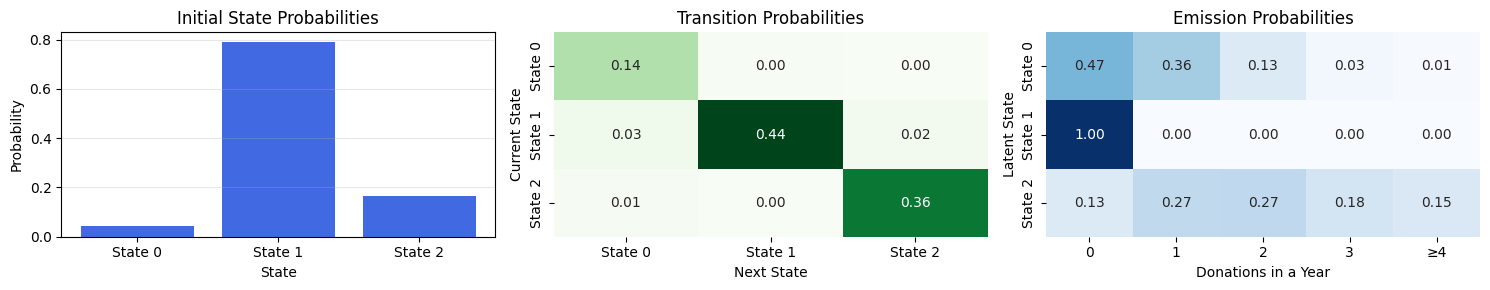

In [ ]:
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Testing

In [ ]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([0.7, 0.2, 0.1])
A_true = torch.tensor([[0.8,0.1,0.1],[0.2,0.7,0.1],[0.3,0.3,0.4]])
rates_true = torch.tensor([1.0, 5.0, 10.0])
T = 2019 - 2009 + 1  # 2010 to 2019 inclusive
states = [torch.multinomial(pi_true, 1).item()]
obs = []
for t in range(T):
    s = states[-1]
    obs.append(torch.poisson(rates_true[s]))
    states.append(torch.multinomial(A_true[s], 1).item())
obs = torch.stack(obs).unsqueeze(0)  # shape [1,T]

def model(observations):
    N, T = observations.shape
    num_states = 3
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

optimizer = Adam({"lr": 0.01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 2000 == 0:
        print(f"Step {step}, loss: {loss}")

Step 0, loss: 88417.765625
Step 100, loss: 85435.1640625
Step 200, loss: 82740.546875
Step 300, loss: 80081.828125
Step 400, loss: 80998.3515625
Step 500, loss: 79612.4140625
Step 600, loss: 80414.671875
Step 700, loss: 80689.640625
Step 800, loss: 81360.8671875
Step 900, loss: 79780.671875


In [ ]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.05394328 0.7997705  0.14628623]
Transition matrix (normalized): [[1.7132293e-01 6.1534988e-03 2.4969937e-04]
 [2.2225181e-02 3.5980791e-01 1.0031948e-02]
 [1.0389977e-02 1.7300758e-03 4.1808882e-01]]
Poisson rates: [7.5455117e-01 1.6380389e-03 2.0974977e+00]


Normalize the values

In [ ]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

Initial state probabilities (normalized): [0.05394328 0.7997705  0.14628623]
Transition matrix (normalized): [[1.7132293e-01 6.1534988e-03 2.4969937e-04]
 [2.2225181e-02 3.5980791e-01 1.0031948e-02]
 [1.0389977e-02 1.7300758e-03 4.1808882e-01]]
Poisson rates: [7.5455117e-01 1.6380389e-03 2.0974977e+00]


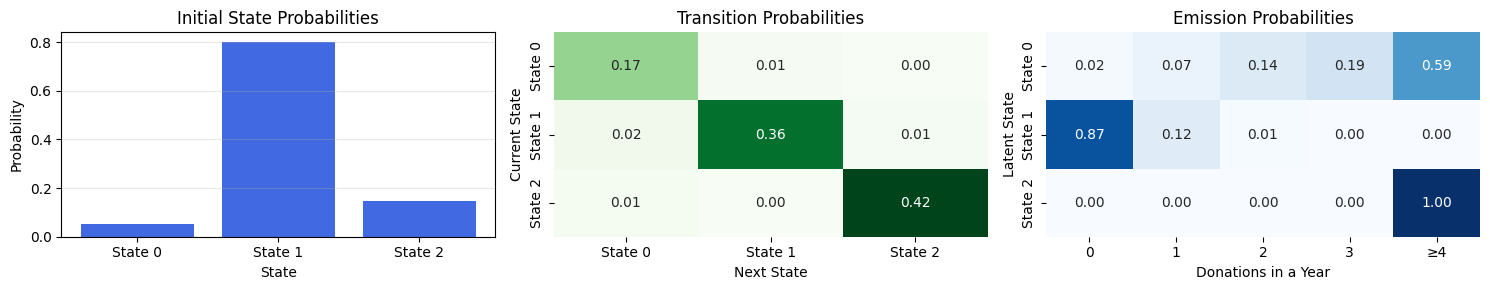

In [ ]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))


optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 187155.9375
Step 10 loss: 166656.890625
Step 20 loss: 244497.5
Step 30 loss: 164927.625
Step 40 loss: 165293.953125
Step 50 loss: 166328.171875
Step 60 loss: 153573.765625
Step 70 loss: 153436.984375
Step 80 loss: 156222.296875
Step 90 loss: 150558.609375
Step 100 loss: 185967.71875
Step 110 loss: 152968.5
Step 120 loss: 151268.21875
Step 130 loss: 160604.765625
Step 140 loss: 148136.921875
Step 150 loss: 148647.28125
Step 160 loss: 147590.75
Step 170 loss: 150282.203125
Step 180 loss: 154472.78125
Step 190 loss: 147647.203125


In [ ]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.0955547  0.10058664 0.80385864]
Transition matrix (normalized): [[2.25919932e-01 7.81546987e-04 1.41205659e-04]
 [4.48093330e-03 6.33835018e-01 1.97169324e-03]
 [1.03996005e-02 4.69259918e-03 1.17777444e-01]]
Poisson rates: [7.5643039e-01 1.5902810e-03 2.0121698e+00]


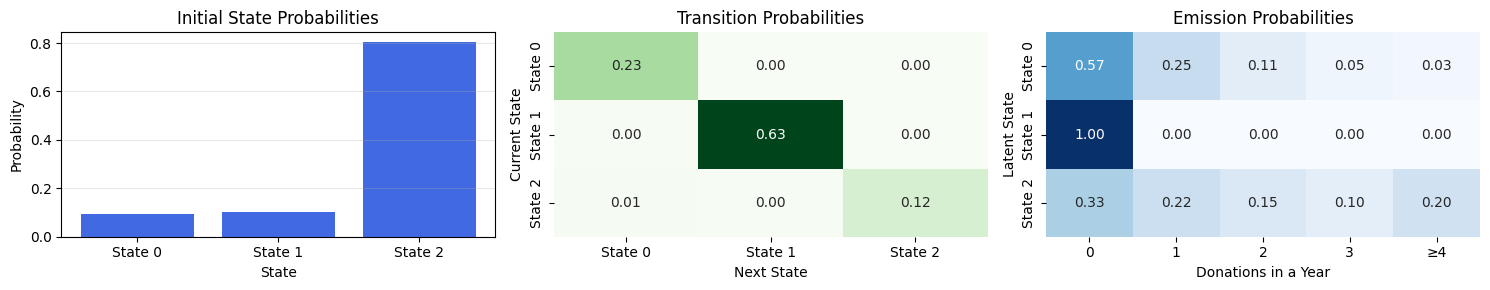

In [ ]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## HMM with covariates